In [ ]:
#| include: false
!pip install git+https://github.com/fastai/fastai
!pip install git+https://github.com/fastai/fastcore

  Cloning https://github.com/fastai/fastai to /tmp/pip-req-build-5l4bq7py
  Running command git clone -q https://github.com/fastai/fastai /tmp/pip-req-build-5l4bq7py
     |████████████████████████████████| 56 kB 2.4 MB/s 
  Created wheel for fastai: filename=fastai-2.5.4-py3-none-any.whl size=186966 sha256=4d4501c9d91b123da60627bdf77fe7f029f05bb846fb365243e1378fdb1093f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-l6qne99_/wheels/40/be/4f/b7f2aec4df5712626ceed9f20a8996eb05e31244e57e58d632
Successfully built fastai
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
  Cloning https://github.com/fastai/fastcore to /tmp/pip-req-build-skll81fb
  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-skll81fb
  Created wheel for fastcore: filename=fastcore-1.3.27-py3-none-any.whl size=55581 sha256=302c137046b97e9511c5cdbaeb7f2a274639e0cd8dde9048cce7b60430c8

# Introduction

In a previous [post](https://nasheqlbrm.github.io/blog/posts/2021-07-31-bear-classification-and-gradio.html#sadness) we saw our Bear classifier confidently predict that an image of a Maine Coone was a Teddy bear. Roughly speaking the problem, in a multi-class setting, is that the exponential (in the softmax) pushes the class with the highest activation to receive a score close to $1$. So while our classifier had never seen a Maine Coone when training, at inference time the image of the Maine Coone happened to push the activations for the Teddy Bear class higher than those for the other classes (Black Bear and Grizzly).

In this post we use multi-label classification to solve this problem following Chapter 6 of @fastbook2020 and the note in @pdito_note_may2020. A multi-label classification problem (as opposed to multi-class classification) is one where there can be multiple labels, instead of there being a single correct class, for every object.

We want our multi-label classifier to predict the different labels present in the object or no label if it is not confident about the presence of any of the labels. For this we switch to using Binary Cross Entropy as our loss function (and will also come up with a threshold probability for our classifier to use for inference).

## Binary Cross Entropy

In [ ]:
from fastai.vision.all import *

Suppose the following are the activations, on a single training example, for the different labels possible in a multi-label classification problem. Pretend that we can have as many as three labels for each image.

In [ ]:
activations = torch.randn(1,3)*3
activations

tensor([[ 0.7260, -3.3489, -2.3491]])

Next suppose the correct labels in this case are the first and third label. A one-hot encoded representation of the labels for this single training example is as follows.

In [ ]:
targets = tensor([[1,0,1]])
targets

tensor([[1, 0, 1]])

The first step is to take the sigmoid activations for each label to convert each activation into a probability score.

In [ ]:
sigmoid_activations = activations.sigmoid()
sigmoid_activations

tensor([[0.6739, 0.0339, 0.0871]])

The next step is to compute the binary cross entropy loss using

In [ ]:
bce_loss = -torch.where(targets==1, sigmoid_activations, 1-sigmoid_activations).log()
bce_loss

tensor([[0.3946, 0.0345, 2.4403]])

When a label is present, in the target, we take the sigmoid activation corresponding to that label. Otherwise, when the label is absent, we take one minus the that sigmoid activation. By doing this we are asking for the confidence that the classifier places on the particular label being absent. 

Thus the binary cross entropy function summarizes the "correctness" of the classifer across the presence and absence of each possible label in a training example. Contrast this with the use of [cross entropy loss](https://nasheqlbrm.github.io/blog/fastai/pytorch/jupyter/2021/08/07/Cross-Entropy-Loss-PyTorch.html) in multi-class classification where we only care about the probability being predicted for the single correct class of the training example.

In [ ]:
results = torch.reshape(torch.cat([activations, sigmoid_activations, targets, bce_loss], 0),(4,3))
pd.DataFrame(results, index=['activations', 'sigmoid','target','loss'])

,0,1,2
activations,0.725968,-3.348915,-2.349130
sigmoid,0.673920,0.033931,0.087135
target,1.000000,0.000000,1.000000
loss,0.394644,0.034520,2.440297


Each row in the dataframe above shows us the step needed to go from an activation to the loss associated with each possible label of a single training example. We can get the losses directly by

In [ ]:
F.binary_cross_entropy_with_logits(activations, targets.float(), reduction="none")

tensor([[0.3946, 0.0345, 2.4403]])

Or by

In [ ]:
nn.BCEWithLogitsLoss(reduction='none')(activations, targets.float())

tensor([[0.3946, 0.0345, 2.4403]])

Of course we will want to take the mean of the loss across the labels using any of the two methods below

In [ ]:
F.binary_cross_entropy_with_logits(activations, targets.float()), nn.BCEWithLogitsLoss()(activations, targets.float())

(tensor(0.9565), tensor(0.9565))

## Soft Labels
In the preceding the labels were hard. In other words, we knew with certainty the labels that are present for any training example. What if we only knew the probability with which a label would be present in a training example?

Feel free to skip to the next section as this is somewhat of a digression.

In the example below we have four training examples and only a single label. The activations for the training examples are as below:

In [ ]:
activations = tensor([[0.0122],[0.2294],[-0.1563],[-0.1483]])
activations.shape

torch.Size([4, 1])

Apply sigmoid to get the predictions for whether the label is present.

In [ ]:
sigmoid_activations = activations.sigmoid()
sigmoid_activations

tensor([[0.5030],
        [0.5571],
        [0.4610],
        [0.4630]])

Get the predictions for whether the label is absent (i.e., some other label is present).

In [ ]:
one_minus_sigmoid_activations = (1. - sigmoid_activations)
one_minus_sigmoid_activations

tensor([[0.4970],
        [0.4429],
        [0.5390],
        [0.5370]])

The targets for each example is as follows. This says that in the first training example label 0 is present with probability 0.5, similarly the probability for label 0 being present in the second example is 0.29 and so on.

In [ ]:
targets = tensor([0.5, 0.29, 0.36, 0.03])
targets.shape

torch.Size([4])

Compute the binary cross entropy loss for each training example.

In [ ]:
bce_loss = -1 * ( targets*sigmoid_activations.flatten().log() + (1. - targets)*( one_minus_sigmoid_activations.flatten().log() ) )
bce_loss

tensor([0.6932, 0.7479, 0.6743, 0.6262])

Compute the average binary cross entropy loss across training examples.

In [ ]:
bce_loss.mean()

tensor(0.6854)

The above can just be done as a one-liner using BCEWithLogitsLossFlat

In [ ]:
BCEWithLogitsLossFlat(reduction='mean')(activations, targets)

TensorBase(0.6854)

Note that we cannot just use nn.BCEWithLogitsLoss because the input tensor isn't flattened and we will get an error. 

*ValueError: Target size (torch.Size([4])) must be the same as input size (torch.Size([4, 1]))*

Now suppose we have two examples and three soft labels per example.

In [ ]:
activations = tensor([[0.0122, 0.001, 0.5],[0.2294, 0.3, 0.75]])
activations.shape

torch.Size([2, 3])

The soft labels are:

In [ ]:
targets = tensor([0.9, 0.1, 0.2],[0.25, 0.5, 0.33 ])
targets.shape

torch.Size([2, 3])

We can compute the binary cross entropy loss in the cumbersome way as below:

In [ ]:
bce_loss = -1 * ( targets * activations.sigmoid().log() + (1. - targets)*( 1.0 - activations.sigmoid() ).log() )
bce_loss, bce_loss.sum(), bce_loss.mean()

(tensor([[0.6883, 0.6935, 0.8741],
         [0.7571, 0.7044, 0.8894]]), tensor(4.6067), tensor(0.7678))

Or just use the one-liner to get the average loss.

In [ ]:
nn.BCEWithLogitsLoss(reduction='mean')(activations, targets)

tensor(0.7678)

I find it useful to think of each individual training example as being replicated as many times as there are possible labels. Then 2 training examples each with 3 possible labels is better thought of as 6 training examples. Hence the average loss, in this setting, requires us to divide by $2*3 = 6$. 

*Note that we could reasonably think that the loss for each label would be summed up into a single loss per training example and we would then divide that by $2$ but do me a favor and don't walk down that path!*

# Bear Images

Now let's get back to our multi-label classification exercise. So we start by assembling images of bears.

In [ ]:
#| code-fold: true
from jmd_imagescraper.core import *

def scrape_images(path, labels, search_suffix, erase_dir=True, max_images=20):
    if erase_dir:
        !rm -rf {path}
    
    if not path.exists():
        path.mkdir(parents=True)
    
    for some_label in labels:
        duckduckgo_search(path, some_label,\
                          f'{some_label} {search_suffix}', max_results=max_images)
        
    filenames = get_image_files(path)
    failed = verify_images(filenames)
    
    failed.map(Path.unlink);
    if failed != []:
        _ = [filenames.remove(f) for f in failed]
    
    # To avoid Transparency warnings, convert PNG images to RGBA
    # https://forums.fast.ai/t/errors-when-training-the-bear-image-classification-model/83422/9
    converted = L()
    for image in filenames:
        if '.png' in str(image):
            im = Image.open(image)
            converted.append(image)  # old file name before resaving
            im.convert("RGBA").save(f"{image}2.png")    
            
    converted.map(Path.unlink); # delete originals
    
    total_images = len(get_image_files(path))
    print(f"After checking for issues, {total_images} (total) images remain.")
    
    return path

In [ ]:
labels = 'grizzly','black','teddy'
path = scrape_images(Path('/data/kaushik/bears'), labels, 'bear', max_images=100)

Duckduckgo search: grizzly bear


Duckduckgo search: black bear


Duckduckgo search: teddy bear


After checking for issues, 300 (total) images remain.


## Set up Data Block

We will need a multicategory block and a function that takes a single label and converts it into a list.

In [ ]:
def get_label_list(some_label): return [some_label]

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=0),
    get_y= Pipeline([parent_label, get_label_list]),
    item_tfms=RandomResizedCrop(228, min_scale=0.5), 
    batch_tfms=aug_transforms())

dls = dblock.dataloaders(path)

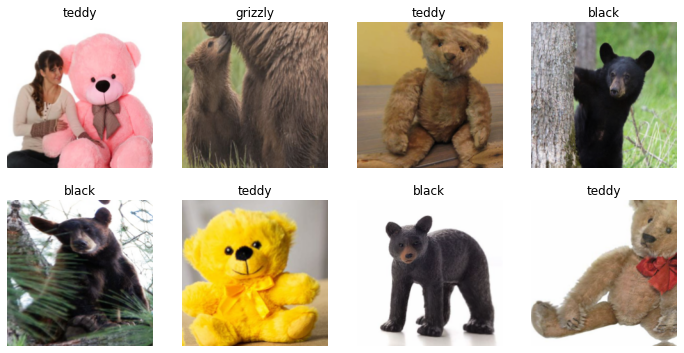

In [ ]:
dls.show_batch(max_n=8, nrows=2)

## Train Model

For the model we will use the fastai's BCEWithLogitsLossFlat to compute the binary cross entropy loss. Another item to note is the use of accuracy_multi as the metric. Accuracy multi is defined as
```
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
```
This shows that accuracy_multi uses the threshold to determine whether a label is present and then takes a mean across the labels for every example in the inputs. The training process does not care about the threshold it only cares about minimizing the loss function.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=[partial(accuracy_multi, thresh=0.95),\
                                            APScoreMulti()], 
                    loss_func=BCEWithLogitsLossFlat())
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,1.037557,0.579388,0.783333,0.868948,00:07


epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,0.497570,0.354649,0.883333,0.960842,00:09
1,0.386510,0.170127,0.961111,0.987437,00:09
2,0.306835,0.135320,0.966667,0.989491,00:09
3,0.263357,0.124831,0.966667,0.989491,00:09


Let's look at the results.

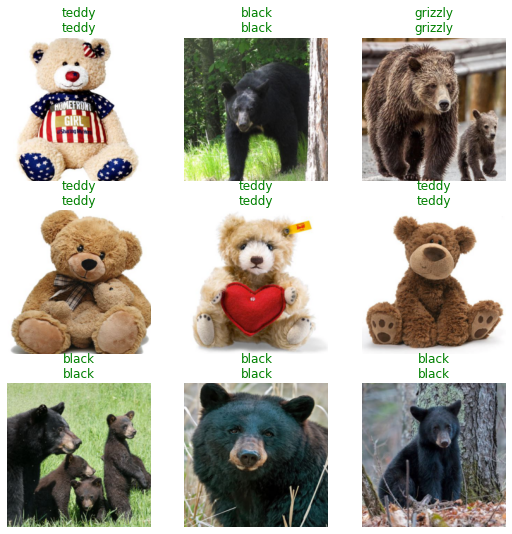

In [ ]:
learn.show_results()

## Sadness revisited
Let's test with our Maine Coon image.

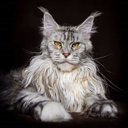

In [ ]:
test_mainecoon_image_location = '../test_images/mc.jpg'
im = Image.open(test_mainecoon_image_location)
im.to_thumb(128,128)

In [ ]:
learn.predict(test_mainecoon_image_location)

((#2) ['black','teddy'],
 tensor([ True, False,  True]),
 tensor([0.5806, 0.0633, 0.8982]))

What happened? Our multi-label classifier still chooses to predict some of the labels.  

Looking at the predicted probabilities we see that none has a score of greater than 0.95 so this means that the threshold we passed in for accuracy_multi is not being used during inference.

If we look at the source of learn.predict we see that it calls out to learn.get_preds(..., with_decoded=True). Per the documentation of [get_predict](https://docs.fast.ai/learner.html#Learner.get_preds) with_decoded=True _will also return the decoded predictions using the decodes function of the loss function (if it exists)._ 

Looking at the definition of BCEWithLogitsLossFlat we see the presence of the decodes method.

```
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)
```

Thus, all we need to do is pass the threshold into BCEWithLogitsLossFlat.

In [ ]:
learn.loss_func = BCEWithLogitsLossFlat(thresh=0.95)
learn.predict(test_mainecoon_image_location)

((#0) [], tensor([False, False, False]), tensor([0.5806, 0.0633, 0.8982]))

Much better. Now none of the labels are predicted.

To get the best threshold we first get all the predictions on the validation set.

In [ ]:
preds,targs = learn.get_preds()

Since the predictions from get_preds has the sigmoid applied already we will pass sigmoid=False when assessing the accuracy_multi at different threshold values .

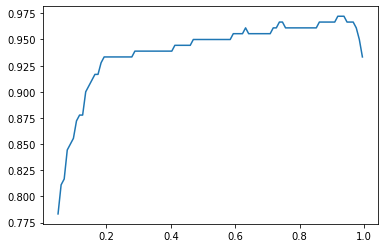

In [ ]:
xs = torch.linspace(0.05,0.995,100)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

Looks like our choice of threshold is fine. One more thing to note is that for multi-label problems it is useful to look at the [average precision score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) using APScoreMulti. This is because on harder datasets it will provide a decidely less rosier view of classifier performance than accuracy_multi.

As a future step it would be nice to do threshold selection for each label following @fan2007study.